In [1]:
# deep_conv_autoencoder_fashion_mnist.py
import os, random, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models

# ---- Reproducibility (optional) ----
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [18]:

# ---- Data ----
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Add channel dimension: (N, 28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

In [8]:

# ---- Hyperparams ----
latent_dim = 30     # size of the latent vector
batch_size = 256
use_denoising = False  # set True to train as a denoising autoencoder
noise_std = 0.25

# Optionally create a noisy view (for denoising autoencoder)
if use_denoising:
    def add_noise(x, std=noise_std):
        noisy = x + np.random.normal(0.0, std, x.shape).astype("float32")
        return np.clip(noisy, 0.0, 1.0)
    x_train_in = add_noise(x_train)
    x_test_in  = add_noise(x_test)
else:
    x_train_in = x_train
    x_test_in  = x_test

In [9]:
# ---- Encoder ----
encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides=2, padding="same")(encoder_inputs)  # 14x14x32
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)               # 7x7x64
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(128, 3, padding="same")(x)                         # 7x7x128
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Flatten()(x)                                              # 7*7*128
x = layers.Dense(256, activation="relu")(x)
z = layers.Dense(latent_dim, name="latent")(x)

encoder = models.Model(encoder_inputs, z, name="encoder")
encoder.summary()

# ---- Decoder ----
latent_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)

x = layers.Conv2DTranspose(128, 3, padding="same")(x)                # 7x7x128
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)      # 14x14x64
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)      # 28x28x32
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)  # 28x28x1
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,166 (6.51 MB)

 Trainable params: 1,706,718 (6.51 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6272)           │       194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 7, 7, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,457 (1.66 MB)

 Trainable params: 435,009 (1.66 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

# ---- Autoencoder ----
ae_inputs = encoder_inputs
x = encoder(ae_inputs)
ae_outputs = decoder(x)
autoencoder = models.Model(ae_inputs, ae_outputs, name="autoencoder")
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")


In [11]:
epochs = 50
# ---- Train ----
history = autoencoder.fit(
    x_train_in, x_train,
    validation_data=(x_test_in, x_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
)


Epoch 1/50
235/235 - 37s - 157ms/step - loss: 0.0245 - val_loss: 0.0972
Epoch 2/50
235/235 - 35s - 151ms/step - loss: 0.0115 - val_loss: 0.0172
Epoch 3/50
235/235 - 41s - 175ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 4/50
235/235 - 49s - 209ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 5/50
235/235 - 49s - 210ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 6/50
235/235 - 46s - 198ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 7/50
235/235 - 46s - 194ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 8/50
235/235 - 47s - 201ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 9/50
235/235 - 51s - 217ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 10/50
235/235 - 48s - 204ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 11/50
235/235 - 49s - 207ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 12/50
235/235 - 47s - 198ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 13/50
235/235 - 48s - 202ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 14/50
235/235 - 48s - 205ms/step - loss: 0.0062 - val_

KeyboardInterrupt: 

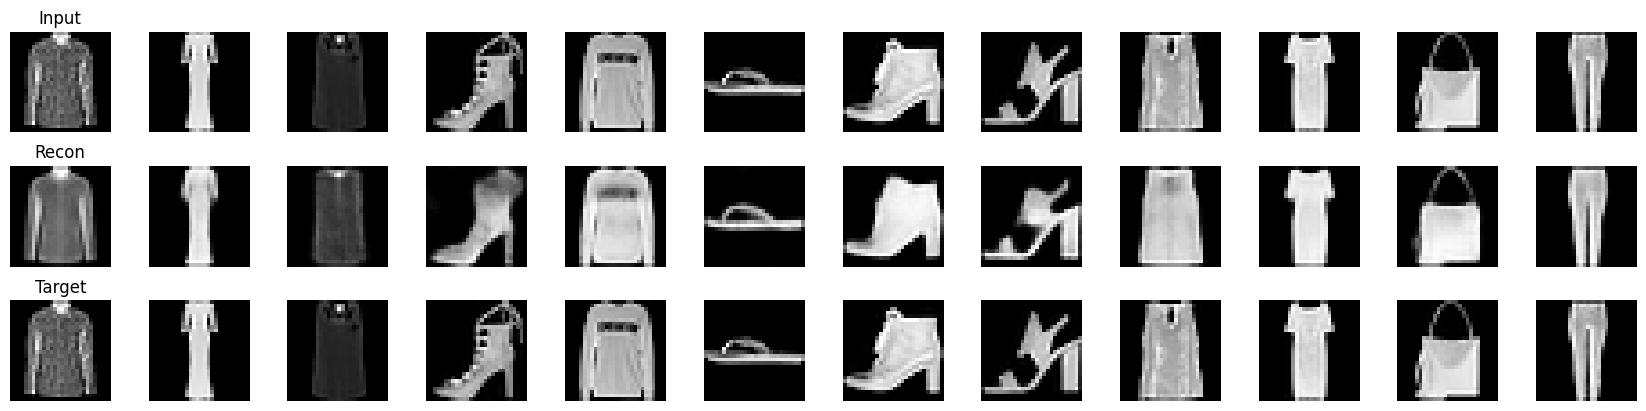

Latent shape: (10000, 30)


In [12]:



# ---- Evaluate & visualize reconstructions ----
import matplotlib.pyplot as plt

def show_reconstructions(model, x_in, x_ref, n=10):
    idx = np.random.choice(len(x_in), n, replace=False)
    x_noisy = x_in[idx]
    x_true = x_ref[idx]
    x_pred = model.predict(x_noisy, verbose=0)

    plt.figure(figsize=(n*1.4, 4.2))
    for i in range(n):
        # Input (possibly noisy)
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_noisy[i].squeeze(), cmap="gray")
        ax.set_title("Input" if i == 0 else "")
        plt.axis("off")
        # Reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(x_pred[i].squeeze(), cmap="gray")
        ax.set_title("Recon" if i == 0 else "")
        plt.axis("off")
        # Target (clean)
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_true[i].squeeze(), cmap="gray")
        ax.set_title("Target" if i == 0 else "")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_reconstructions(autoencoder, x_test_in, x_test, n=12)

# ---- Optional: extract latent codes for downstream use ----
z_test = encoder.predict(x_test, verbose=0)
print("Latent shape:", z_test.shape)


In [15]:
X_valid_compressed = encoder.predict(x_test_in)
X_valid_compressed.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(10000, 30)

In [20]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = encoder.predict(x_test)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [27]:
X_valid_compressed.shape

(10000, 30)

In [28]:
X_valid_2D.shape

(10000, 2)

In [24]:
import matplotlib as mpl

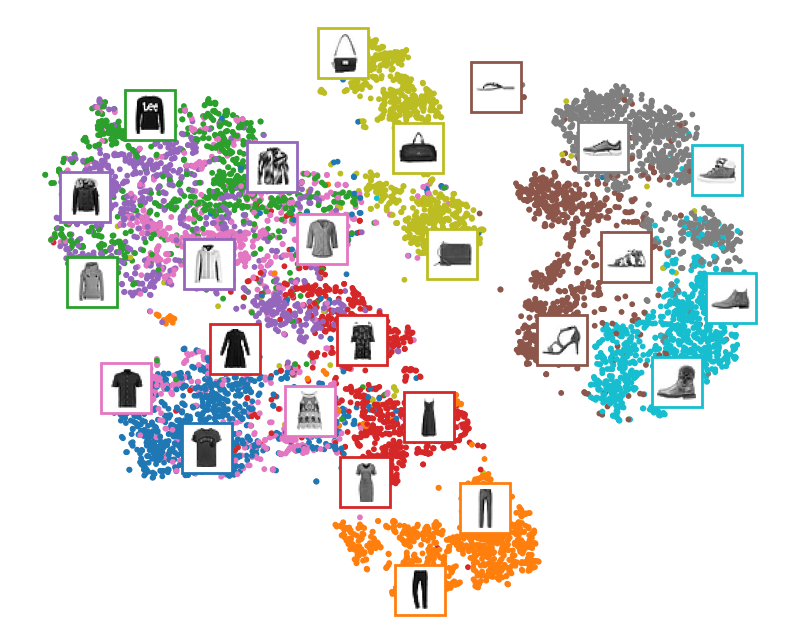

In [29]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
# save_fig("fashion_mnist_visualization_plot")
plt.show()

In [91]:
imgs = x_test[8:10]

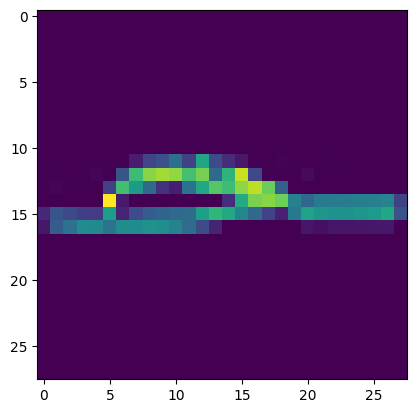

In [92]:
plt.imshow(imgs[0,:, :, 0])

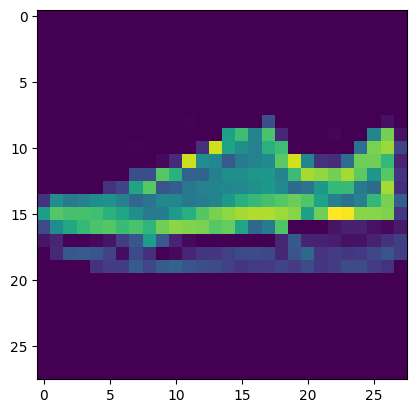

In [93]:
plt.imshow(imgs[1,:, :, 0])

In [94]:
codings = encoder.predict(imgs)
new_codings = codings.mean(axis=0)
new_codings = new_codings.reshape((1, 30))
new_obj= decoder.predict(new_codings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


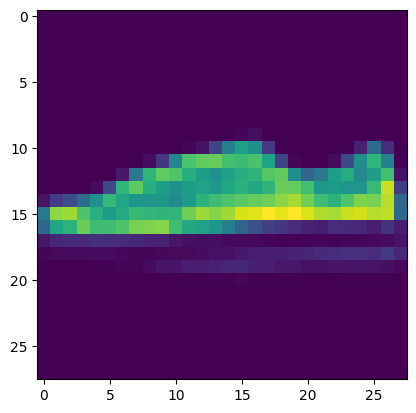

In [95]:
plt.imshow(new_obj[0,:,:, 0])